In [773]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [774]:
train_dir = 'Minggu 4/images/training/'
test_dir = 'Minggu 4/images/test/'

In [775]:
def standarized_input(image):
    # mengubah warna gambar ke RGB
    std_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # mengubah ukuran gambar ke 1100x600
    std_img = cv2.resize(std_img, (1100,600))

    return std_img

In [776]:
def load_dataset(img_dir, img_ext = 'jpg'):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.' + img_ext):
            img = cv2.imread(file)
            img = standarized_input(img)

            if not img is None:
                img_list.append((img, label))

    return img_list

### Membuat data train

In [777]:
train_img = load_dataset(train_dir)

### Ekstraksi Fitur

In [778]:
def label_encoder(label):
    # melakuakan encoding label
    # 0 = night || 1 = day

    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

In [779]:
def extract_histogram(image):
    # mengambil histogram dari gambar
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # melakukan normalisasi histogram
    hist_norm = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

    return hist_norm

In [780]:
def extract_avg_intensity(img, threshold=40):
    
    # mengubah gambar menjadi grayscale untuk mempercepat proses
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = extract_histogram(img)

    # fitur 1: mendapatkan rata-rata intensitas piksel yang berada di bawah threshold
    # night
    avg_low_hist = [np.mean(hist[:threshold])]

    # fitur 2: mendapatkan rata-rata intensitas piksel yang berada di atas threshold
    # day
    avg_high_hist = [np.mean(hist[threshold:])]

    return avg_low_hist, avg_high_hist

In [781]:
def extract_avg_color(img):
    # menghitung rata-rata warna yang akan digunakan sebagai fitur
    avg_color = cv2.mean(img)[:3]
    return avg_color

In [782]:
rand_num = np.random.randint(0, len(train_img))

AVERAGE LOW INTENSITY HISTOGRAM:  [np.float32(89.45485)]
AVERAGE HIGH INTENSITY HISTOGRAM:  [np.float32(1.3432832)]
AVERAGE COLOR:  (30.44365, 15.39744090909091, 10.420556060606062)


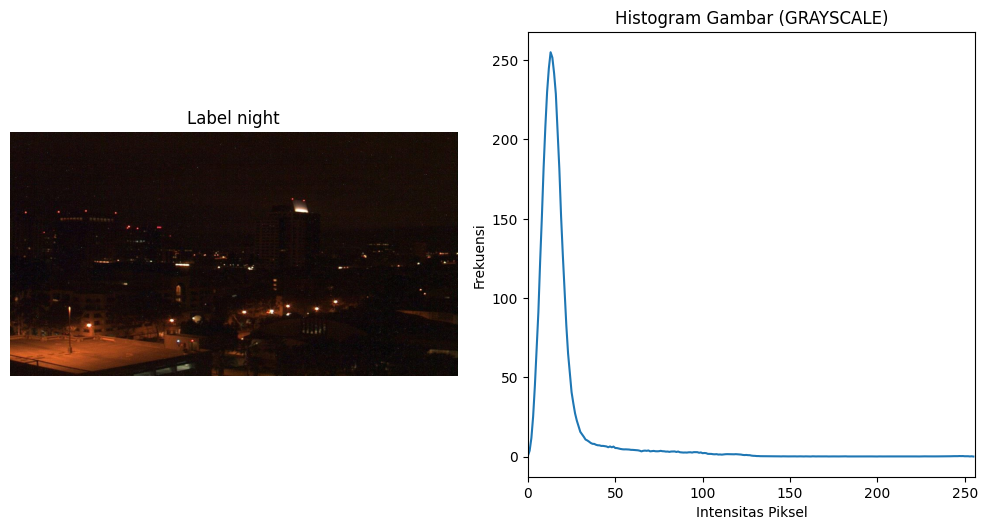

In [783]:
img = train_img[rand_num]

img_gray = cv2.cvtColor(img[0], cv2.COLOR_RGB2GRAY)
hist = extract_histogram(img_gray)
avg_low_hist, avg_high_hist = extract_avg_intensity(img[0])
avg_color = extract_avg_color(img[0])

print("AVERAGE LOW INTENSITY HISTOGRAM: ", avg_low_hist)
print("AVERAGE HIGH INTENSITY HISTOGRAM: ", avg_high_hist)
print("AVERAGE COLOR: ", avg_color)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(img[0])
plt.title("Label " + str(img[1]))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.plot(hist)
plt.title('Histogram Gambar (GRAYSCALE)')
plt.xlabel('Intensitas Piksel')
plt.ylabel('Frekuensi')
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

In [784]:
def preprocess(img_list):
    # fitur 1
    low_intensity_list = []

    # fitur 2
    high_intensity_list = []

    # fitur 3
    avg_color_list = []
    labels = []

    for img in img_list:
        avg_low_hist, avg_high_hist = extract_avg_intensity(img[0])
        avg_color = extract_avg_color(img[0])
        encoded_label = label_encoder(img[1])

        avg_color_list.append(avg_color)
        low_intensity_list.append(avg_low_hist)
        high_intensity_list.append(avg_high_hist)
        labels.append(encoded_label)

    # Stack the data and create a DataFrame
    data = np.column_stack((low_intensity_list, high_intensity_list, avg_color_list, labels))
    
    df = pd.DataFrame(data, columns=['LOW_INTENSITY', 'HIGH_INTENSITY', 'AVG_RED', "AVG_GREEN", 'AVG_BLUE', 'LABEL'])

    return df

### Pre-process image dengan setelah melakukan mendapatkan fitur yang diperlukan

In [785]:
# melakukan preprocessing pada data train
train_std_img_list = preprocess(train_img)

In [786]:
train_std_img_list.head()

,LOW_INTENSITY,HIGH_INTENSITY,AVG_RED,AVG_GREEN,AVG_BLUE,LABEL
0,1.094654,32.501026,170.303739,159.354871,153.942329,1.0
1,98.568695,97.693962,93.646700,94.577455,93.567376,1.0
2,1.788912,37.621307,111.085841,111.773770,124.231082,1.0
3,1.291903,20.460705,108.273376,112.184479,125.053480,1.0
4,38.106815,64.373932,109.275239,100.678629,94.962332,1.0


In [787]:
# mengambil data testing
test_img = load_dataset(test_dir)

# melakukan preprocessing pada data testing
test_std_img_list = preprocess(test_img)

In [788]:
test_std_img_list.head()

,LOW_INTENSITY,HIGH_INTENSITY,AVG_RED,AVG_GREEN,AVG_BLUE,LABEL
0,51.605530,60.594376,105.683352,98.566477,94.601026,1.0
1,1.797982,21.121048,151.285898,170.289600,176.702633,1.0
2,0.093830,41.383614,151.874836,149.935327,149.471868,1.0
3,1.010832,32.074612,168.191115,158.487864,150.243541,1.0
4,0.654748,13.886242,173.579189,169.768139,142.670465,1.0


### Melatih Model dengan menggunakan SVM

In [789]:
from sklearn.svm import SVC

X_train = train_std_img_list.iloc[:, :-1].values
y_train = train_std_img_list.iloc[:, -1].values
X_test = test_std_img_list.iloc[:, :-1].values
y_test = test_std_img_list.iloc[:, -1].values

model = SVC()
model.fit(X_train, y_train)

SVC()

### Evaluasi Model

In [790]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)

print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.9875
Accuracy on test: 0.93125


### Melakukan Prediksi 

In [791]:
predict_images_path = 'Minggu 4/predict_images/'

predict_images = load_dataset(predict_images_path, img_ext='png')

Gambar 6
Label: night
Prediksi: night
True or False: True


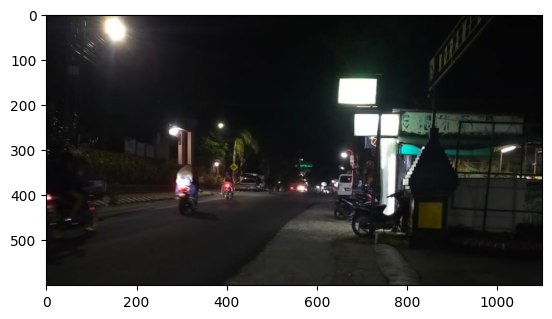

In [792]:
rand_num = np.random.randint(0, len(predict_images))

pred_img = predict_images[rand_num][0]
label = predict_images[rand_num][1]

# Standarisasi gambar prediksi
pred_img_std = standarized_input(pred_img)

# Ekstraksi fitur dari gambar prediksi
avg_low_hist, avg_high_hist = extract_avg_intensity(pred_img_std)
avg_color = extract_avg_color(pred_img_std)

# Menggabungkan fitur
features = [avg_low_hist[0], avg_high_hist[0]] + list(avg_color)

# Melakukan prediksi
prediction = model.predict(np.array(features).reshape(1, -1))
prediction_str = 'day' if prediction[0] == 1 else 'night'

print(f'Gambar {rand_num}')
print(f'Label: {label}')
print(f'Prediksi: {prediction_str}')
print(f'True or False: {'True' if label == prediction_str else 'False'}')

plt.imshow(predict_images[rand_num][0])